# Titianic Kaggale

## Link: [Kaggle](https://www.kaggle.com/c/titanic)

## Based from 

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (12.0, 10.0) # set default size of plots
%matplotlib inline

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV

## My libs
from tqdm import tqdm
from xgboost import XGBClassifier
import xgboost as xgb

/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this mod

In [2]:
# Load in the train and test datasets
Train = pd.read_csv('Data/train.csv')
Test = pd.read_csv('Data/test.csv')

# Store our passenger ID for easy access
PassengerId = Test['PassengerId']

## head
Train.head(10)
# '''
# Variable	Definition	Key
# survival	Survival	0 = No, 1 = Yes
# pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
# sex	Sex	
# Age	Age in years	
# sibsp	# of siblings / spouses aboard the Titanic	
# parch	# of parents / children aboard the Titanic	
# ticket	Ticket number	
# fare	Passenger fare	
# cabin	Cabin number	
# embarked	Port of Embarkation
# '''

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


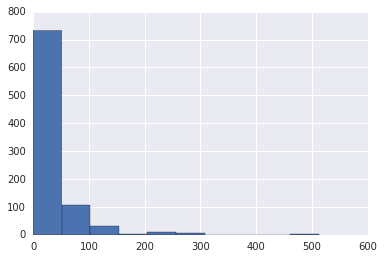

In [19]:
#print(Train.columns, test.columns)
#print (Train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())
#print (Train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())
#print (Train[["Age", "Survived"]].groupby(['Age'], as_index=False).mean())
#print (Train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean())
#print (Train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean())
#print (Train[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean())
#print(test["Sex"].unique())
plt.clf()
#Train['Age'].hist()
Train['Fare'].hist()
plt.show()

In [3]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [21]:
full_data = [copy.deepcopy(Train), copy.deepcopy(Test)]

for dataset in full_data:
    
    # Gives the length of the name
    dataset['Name_length'] = dataset['Name'].apply(len)
    
    # Feature that tells whether a passenger had a cabin on the Titanic
    dataset['Has_Cabin'] = dataset["Cabin"].apply(lambda x: 0 if type(x) == str else 1)

    # Feature engineering steps taken from Sina
    # Create new feature FamilySize as a combination of SibSp and Parch
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

    # Create new feature IsAlone from FamilySize
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

    # Remove all NULLS in the Embarked column
    dataset['Embarked'] = dataset['Embarked'].fillna('Z')

    # Create a new feature CategoricalFare
    # Remove all NULLS in the Fare column and 
    # Maybe not Median?

    dataset['Fare'] = dataset['Fare'].fillna(full_data[0]['Fare'].median())
    dataset['CategoricalFare'] = pd.qcut(dataset['Fare'], 4)

    # Create a New feature CategoricalAge
    # This could be engineered?
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    dataset['CategoricalAge'] = pd.cut(dataset['Age'], 5)
    
    # Create a new feature Title, containing the titles of passenger names
    dataset['Title'] = dataset['Name'].apply(get_title)
    # Group all non-common titles into one single grouping "Rare"
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1, '': 2} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2, 'Z': 3} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']                               = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 100), 'Fare']      = 3
    dataset.loc[(dataset['Fare'] > 100), 'Fare']                                = 4
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 4, 'Age']                           = 0
    dataset.loc[(dataset['Age'] > 4) & (dataset['Age'] <= 16), 'Age']  = 1
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 4
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 5

/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','CategoricalAge', 'CategoricalFare']
for dataset in full_data:
    dataset.drop(drop_elements, axis = 1, inplace=True)
    #print(dataset.head(3))

In [23]:
train = full_data[0]
test  = full_data[1]
print(train.shape, test.shape)

(891, 12) (418, 11)


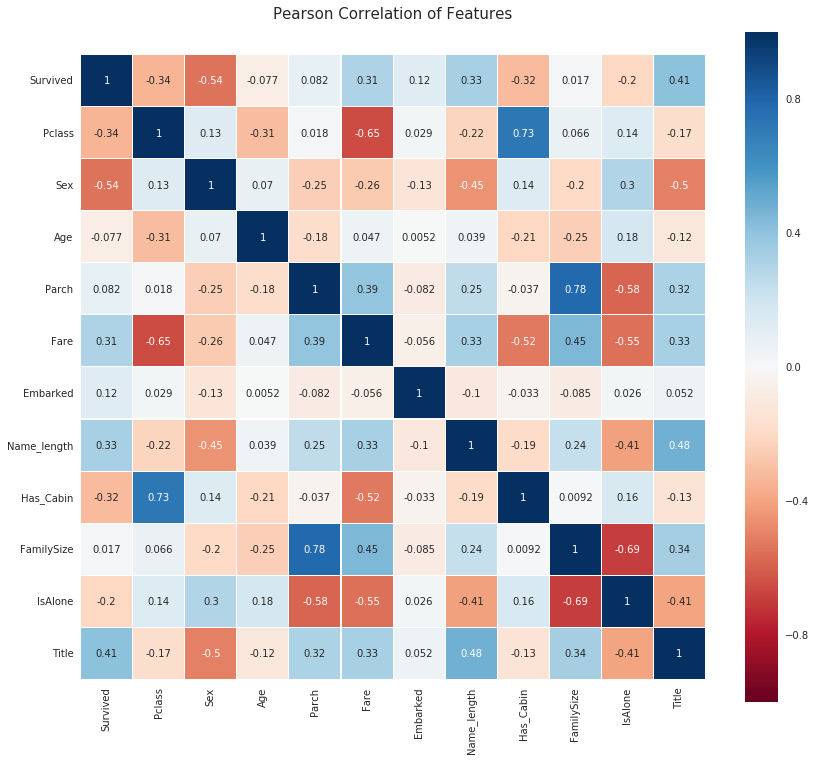

In [24]:
colormap = plt.cm.RdBu
plt.clf()
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

## Let's XGboost and CV this

In [25]:
train_t, val_t = train_test_split(train, train_size=0.8, test_size=0.2)
# X_train = train_t.drop("Survived", axis=1)
# y_train = train_t["Survived"]
# X_val = val_t.drop("Survived", axis=1)
# y_val = val_t["Survived"]

In [76]:
## A new more systematic approach
def modelfit(alg, dtrain, useTrainCV=True, param_grid={}, cv_folds=5, early_stopping_rounds=50):
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
#https://www.dataiku.com/learn/guide/code/python/advanced-xgboost-tuning.html   
    df_tr_temp, df_vr_temp = train_test_split(dtrain, train_size=0.8)
    X_tr_temp = df_tr_temp.drop("Survived", axis=1)
    y_tr_temp = df_tr_temp["Survived"]
    X_vr_temp = df_vr_temp.drop("Survived", axis=1)
    y_vr_temp = df_vr_temp["Survived"]
    
    if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain["is_sig"].values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
        
#         ##Randomized Search CV
#         random_search = RandomizedSearchCV(alg, param_grid, n_iter=5, cv=3, refit=True, verbose=2, n_jobs=2)
#         random_search.fit(X_tr_temp, y_tr_temp)
#         report(random_search.cv_results_)
        
        #Grid search CV
        gsearch1 = GridSearchCV(estimator = alg, param_grid = param_grid, n_jobs=4, iid=False, cv=5)
        gsearch1.fit(X_tr_temp, y_tr_temp)
        print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    
    alg.fit(X_tr_temp, y_tr_temp, sample_weight=None, 
            eval_set=[(X_tr_temp, y_tr_temp), (X_vr_temp, y_vr_temp)],
            eval_metric="error", verbose=True)
        
    #Predict training set:
    tr_predictions = alg.predict(X_tr_temp)
    tr_predprob    = alg.predict_proba(X_tr_temp)[:,1]
    vr_predictions = alg.predict(X_vr_temp)
    vr_predprob    = alg.predict_proba(X_vr_temp)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Train Accuracy : %.4g" % metrics.accuracy_score(y_tr_temp.values, tr_predictions))
    print("Train AUC Score (Train): %f" % metrics.roc_auc_score(y_tr_temp, tr_predprob))
    #Validation report
    print("Val Accuracy : %.4g" % metrics.accuracy_score(y_vr_temp.values, vr_predictions))
    print("Val AUC Score (Val): %f" % metrics.roc_auc_score(y_vr_temp, vr_predprob))
    
    return True

In [77]:
def training(df, name="xgb_temp", optimize=False):
    
    param_grid = {
            'learning_rate': [.05, .3], 
            'max_depth': [3, 4, 5, 6], 
            #'gamma' : [0.01, .1], 
            #'subsample': [.5, .9], 
            #'colsample_bytree': [.5, .9]
    }
    
    xgb_temp = XGBClassifier(
        max_depth = 7, #Maximum tree depth for base learners.
        learning_rate = 1e-7, #Boosting learning rate (XGBoost's "eta")
        n_estimators= 15, ## Number of boosted trees, CV doesn't change after ~ 90
        ##silent = False, ##print messages or not
        objective= 'binary:logistic',
        nthread=-1,
        gamma=0.01, #Minimum loss reduction required to make a further partition on a leaf node of the tree.
        min_child_weight=1, # Minimum sum of instance weight(hessian) needed in a child.
        scale_pos_weight=1,
        reg_alpha=0.1,
        reg_lambda=0.1,
        subsample=0.7, #Subsample ratio of the training instance.
        colsample_bytree = 0.9, #Subsample ratio of columns when constructing each tree.
        seed=24)
    
    if optimize:
        modelfit(xgb_temp, df, param_grid=param_grid)
        joblib.dump(param_grid.best_estimator_, name + ".parlib.dat")
    else:
        modelfit(xgb_temp, df, useTrainCV=False)
    
    ##save model
    joblib.dump(xgb_temp, name + ".joblib.dat")
    ##load model
    #loaded_model = joblib.load("pima.joblib.dat")
    
#     ##finish and plot
#     plt.clf()
#     fig = plt.figure(figsize=(10,6))
#     feat_imp = pd.Series(xgb_temp._Booster.get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')
#     plt.savefig('Plot/feature_ranking_' + name + '.pdf')
    
    return xgb_temp

# Test performance on test set
def evaluate(alg):
    X_vr_temp = val_t.drop("Survived", axis=1)
    y_vr_temp = val_t["Survived"]
    vr_predictions = alg.predict(X_vr_temp)
    vr_predprob    = alg.predict_proba(X_vr_temp)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Test Accuracy : %.4g" % metrics.accuracy_score(y_vr_temp.values, vr_predictions))
    print("Test AUC Score (Test): %f" % metrics.roc_auc_score(y_vr_temp, vr_predprob))
    #Validation report

In [78]:
xgb_0 = training(train_t, name="xgb_0", optimize=False)
evaluate(xgb_0)

[0]	validation_0-error:0.188049	validation_1-error:0.167832
[1]	validation_0-error:0.16696	validation_1-error:0.216783
[2]	validation_0-error:0.156415	validation_1-error:0.181818
[3]	validation_0-error:0.144112	validation_1-error:0.188811
[4]	validation_0-error:0.13884	validation_1-error:0.174825
[5]	validation_0-error:0.133568	validation_1-error:0.181818
[6]	validation_0-error:0.135325	validation_1-error:0.188811
[7]	validation_0-error:0.137083	validation_1-error:0.174825
[8]	validation_0-error:0.126538	validation_1-error:0.181818
[9]	validation_0-error:0.13181	validation_1-error:0.188811
[10]	validation_0-error:0.130053	validation_1-error:0.174825
[11]	validation_0-error:0.128295	validation_1-error:0.174825
[12]	validation_0-error:0.128295	validation_1-error:0.174825
[13]	validation_0-error:0.119508	validation_1-error:0.174825
[14]	validation_0-error:0.121265	validation_1-error:0.181818

Model Report
Train Accuracy : 0.8787
Train AUC Score (Train): 0.931860
Val Accuracy : 0.8182
Val 

In [79]:
# Generate Submission File 
model = xgb_0
predictions = model.predict(test)
submit = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
submit.head()
submit.to_csv("Data/Submission.csv", index=False)